In [1]:
from pyomo.environ import *
import pandas as pd
import matplotlib.pyplot as plt
import sys
plt.style.use({'figure.facecolor':'white'})

c:\python37\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


    price  price_max_dev_up  price_max_dev_down
t1    120             120.0               120.0
t2     75             105.0                45.0
t3    110             154.0                66.0
t4     60              84.0                36.0
Just redo the plot from the chapter


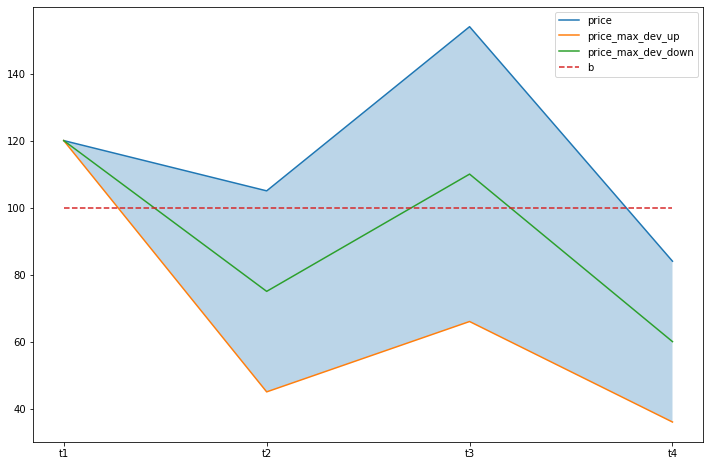

In [2]:
b = 100         #$/MWh
U_h = 3         #kwh
U_up = 8        #kwh
U_down = 6      #kwh
R_up = 1.5      #kwh
R_down = 1.5    #kwh
u0 = 0          #kwh
gamma = 2
max_dev = 0.4   #$/MWh

data = pd.read_excel('data.xlsx', index_col=0)
data['price_max_dev_up'] = data['price']
data['price_max_dev_down'] = data['price']
data['price_max_dev_up'][1:] = data['price'][1:]*(1+max_dev)
data['price_max_dev_down'][1:] = data['price'][1:]*(1-max_dev)
print(data)

print('Just redo the plot from the chapter')
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(data.index, data[['price_max_dev_up', 'price_max_dev_down']])
ax.fill_between(data.index, data['price_max_dev_up'], data['price_max_dev_down'], alpha=0.3)
ax.plot(data.index, data['price'])
ax.plot(data.index, [b]*4, '--', label='b')
ax.legend(data.columns.append(pd.Index(['b'])));


In [3]:
model = ConcreteModel()

# DEFINE SETS
#skip the initial deterministic time step
model.T_rob = Set(ordered=True, initialize=data.index[1:])

# DEFINE PARAMETERS
model.lamb_dev = Param(model.T_rob, within=NonNegativeReals, mutable=True)

# INITIALIZE PARAMETERS
for t in model.T_rob:
    model.lamb_dev[t] = data.loc[t,'price']*max_dev

# DEFINE VARIABLES
#initial consumption
model.u_1 = Var(within=NonNegativeReals)
#consumption after initial time step (t2, t3, t4)
model.u_rob = Var(model.T_rob, within=NonNegativeReals)
model.beta = Var(within=NonNegativeReals)
model.xi = Var(model.T_rob, within=NonNegativeReals)

# DEFINE COST AND CONSTRAINTS

#9.15a
# def cost_rule(model):
#     return (120 - b)*model.u_1 + sum((data.loc[t,'price']-b)*model.u_rob[t] for t in model.T_rob) \
#             - sum(b*model.u_rob[t] - model.xi[t] for t in model.T_rob) + gamma*model.beta
# model.cost = Objective(rule=cost_rule)

def cost_rule(model):
    return (120 - b)*model.u_1 + sum((data.loc[t,'price']-b)*model.u_rob[t] for t in model.T_rob) \
            + sum(model.xi[t] for t in model.T_rob) + gamma*model.beta
model.cost = Objective(rule=cost_rule)

#9.15c
def dual_constr_rule(model, t):
    return model.xi[t] + model.beta >= model.lamb_dev[t]*model.u_rob[t]
model.dual_constr = Constraint(model.T_rob, rule=dual_constr_rule)

#9.15b g(x,u)>=0 equation 9.1b initial case
def ramp_up_rule_det(model):
    return model.u_1 - u0 <= R_up
model.ramp_up_det = Constraint(rule=ramp_up_rule_det)

#9.15b g(x,u)>=0 equation 9.1b other time frames
def ramp_up_rule_rob(model, trob):
    if model.T_rob.ord(trob) == 1:
        return model.u_rob[trob] - model.u_1 <= R_up
    else:
        return model.u_rob[trob] - model.u_rob[model.T_rob.prev(trob)] <= R_up
model.ramp_up_rob = Constraint(model.T_rob, rule=ramp_up_rule_rob)

#9.15b g(x,u)>=0 equation 9.1c initial case
def ramp_down_rule_det(model):
    return model.u_1 - u0 >= -R_down
model.ramp_down_det = Constraint(rule=ramp_down_rule_det)

#9.15b g(x,u)>=0 equation 9.1c other time frames
def ramp_down_rule_rob(model, trob):
    if model.T_rob.ord(trob) == 1:
        return model.u_rob[trob] - model.u_1 >= -R_down
    else:
        return model.u_rob[trob] - model.u_rob[model.T_rob.prev(trob)] >= -R_down
model.ramp_down_rob = Constraint(model.T_rob, rule=ramp_down_rule_rob)

#9.15b g(x,u)>=0 equation 9.1d and g combined
def minmax_cons_rule_det(model):
    return inequality(0, model.u_1, U_h)
model.minmax_const_det = Constraint(rule=minmax_cons_rule_det)

#9.15b g(x,u)>=0 equation 9.1e
def minmax_cons_rule_rob(model, t):
    return inequality(0, model.u_rob[t], U_h)
model.minmax_const_rob = Constraint(model.T_rob, rule=minmax_cons_rule_rob)

#9.15b g(x,u)>=0 equation 9.1f
def minmax_total_rule(model, t):
    return inequality(U_down, model.u_1 + sum(model.u_rob[t] for t in model.T_rob), U_up)
model.minmax_total = Constraint(model.T_rob, rule=minmax_total_rule)

In [4]:
#model.pprint()

In [5]:
opt = SolverFactory('ipopt')
results = opt.solve(model)

In [6]:
resData = pd.DataFrame(index=data.index, columns=['Consumption (kWh)', 'Price ($/MWh)'])
resData.loc['t1', 'Consumption (kWh)'] = value(model.u_1)
resData.loc['t1', 'Price ($/MWh)'] = 120
for t in model.T_rob:
    resData.loc[t, 'Consumption (kWh)'] = value(model.u_rob[t])
    # is this the right way to get price?
    resData.loc[t, 'Price ($/MWh)'] = value(model.xi[t])*value(model.lamb_dev[t]) + data.loc[t,'price']
print(resData)
value(model.cost())


   Consumption (kWh) Price ($/MWh)
t1          0.283784           120
t2           1.78378            75
t3           1.21622           110
t4           2.71622       340.216


-16.702703610911243